# Cancer Documents Classification

In [4]:
# Importing the libraries
#!pip install tensorflow_addons
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import torch
import keras
import tensorflow as tf

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Input, LSTM, concatenate, Embedding, Flatten, BatchNormalization
from keras.models import Model
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow_addons.metrics import F1Score
from sklearn.metrics import accuracy_score, confusion_matrix

In [5]:
# Loading the data
df = pd.read_csv('alldata_1_for_kaggle.csv', encoding='ISO-8859-1')
df.head()

,Unnamed: 0,0,a
0,0,Thyroid_Cancer,Thyroid surgery in children in a single insti...
1,1,Thyroid_Cancer,""" The adopted strategy was the same as that us..."
2,2,Thyroid_Cancer,coronary arterybypass grafting thrombosis ï¬b...
3,3,Thyroid_Cancer,Solitary plasmacytoma SP of the skull is an u...
4,4,Thyroid_Cancer,This study aimed to investigate serum matrix ...


In [6]:
# Dropping the unnecessary column and renaming them
df.drop('Unnamed: 0', axis = 1, inplace = True)
df.columns = ['Cancer Type', 'Text']
df.head()

,Cancer Type,Text
0,Thyroid_Cancer,Thyroid surgery in children in a single insti...
1,Thyroid_Cancer,""" The adopted strategy was the same as that us..."
2,Thyroid_Cancer,coronary arterybypass grafting thrombosis ï¬b...
3,Thyroid_Cancer,Solitary plasmacytoma SP of the skull is an u...
4,Thyroid_Cancer,This study aimed to investigate serum matrix ...


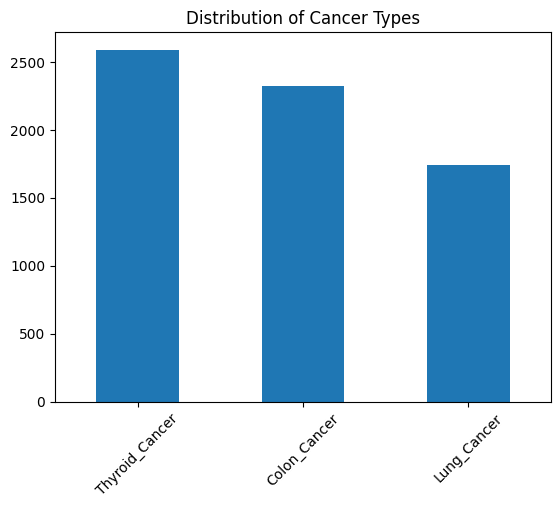

In [7]:
# Plotting the distribution of cancer types in the data
df['Cancer Type'].value_counts().plot(kind ='bar')
plt.xticks(rotation = 45)
plt.title('Distribution of Cancer Types')
plt.show()

In [8]:
df = df[(df['Cancer Type'] == 'Thyroid_Cancer') | (df['Cancer Type'] == 'Colon_Cancer')]

In [9]:
# Preprocessing the text
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


def preprocess_text(text):
    # Remove special characters and digits
    text = re.sub("(\\d|\\W)+", " ", text)
    
    # Tokenize the text into words
    tokens = word_tokenize(text.lower())
    
    # Remove stop words from the tokens
    stop_words = set(stopwords.words("english"))
    filtered_tokens = [token for token in tokens if token not in stop_words]
    
    # Lemmatize the words using WordNetLemmatizer
    lemmatizer = WordNetLemmatizer()
    lemma_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]
    
    # Join the words back into a string and return
    return " ".join(lemma_tokens)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [11]:
df['Preprocessed Text'] = df['Text'].apply(preprocess_text)
df.head()

,Cancer Type,Text,Preprocessed Text
0,Thyroid_Cancer,Thyroid surgery in children in a single insti...,thyroid surgery child single institution osama...
1,Thyroid_Cancer,""" The adopted strategy was the same as that us...",adopted strategy used prior year based four ex...
2,Thyroid_Cancer,coronary arterybypass grafting thrombosis ï¬b...,coronary arterybypass grafting thrombosis ï br...
3,Thyroid_Cancer,Solitary plasmacytoma SP of the skull is an u...,solitary plasmacytoma sp skull uncommon clinic...
4,Thyroid_Cancer,This study aimed to investigate serum matrix ...,study aimed investigate serum matrix metallopr...


In [12]:
# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df['Preprocessed Text'], df['Cancer Type'], random_state = 0, test_size = 0.2, stratify = df['Cancer Type'])

In [13]:
# Convert the labels into numbers
def labels(label):
  if label == 'Thyroid_Cancer':
    return 0
  elif label == 'Colon_Cancer':
    return 1

labels_train = y_train.apply(labels)
labels_test = y_test.apply(labels)

In [14]:
# Set device to GPU if available, else CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [15]:
# Using the tokenizer into numeric representation
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
preprocessed_text_train = tokenizer.texts_to_sequences(X_train)
preprocessed_text_test = tokenizer.texts_to_sequences(X_test)

In [16]:
# Length of sentences
len_train = []
for i in preprocessed_text_train:
  len_train.append(len(i))

pd.DataFrame(len_train).describe(percentiles = [0, 0.25, 0.5, 0.77, 0.9, 0.95, 0.96, 0.97, 0.98, 0.99]).T

# Selecting the maximum length of 2830

,count,mean,std,min,0%,25%,50%,77%,90%,95%,96%,97%,98%,99%,max
0,3928.0,2846.92057,557.968651,54.0,54.0,2830.0,3007.0,3162.0,3265.0,3334.0,3366.0,3423.42,3477.0,3486.0,3789.0


In [17]:
pad_train = pad_sequences(preprocessed_text_train, maxlen = 2830, padding = 'post')
pad_test = pad_sequences(preprocessed_text_test, maxlen = 2830, padding = 'post')

In [26]:
# Model Building using LSTM
inp = Input(shape = (2830, ))
lstm = LSTM(units = 32)(tf.expand_dims(inp, axis=-1))
lstm = BatchNormalization()(lstm)
flatten = Flatten()(lstm)
dense = Dense(32, activation = 'relu')(flatten)
dense = Dense(1, activation = 'sigmoid')(dense)
model = Model(inputs = inp, outputs = dense)

In [27]:
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 2830)]            0         
                                                                 
 tf.expand_dims_26 (TFOpLamb  (None, 2830, 1)          0         
 da)                                                             
                                                                 
 lstm_26 (LSTM)              (None, 32)                4352      
                                                                 
 batch_normalization_11 (Bat  (None, 32)               128       
 chNormalization)                                                
                                                                 
 flatten_4 (Flatten)         (None, 32)                0         
                                                                 
 dense_8 (Dense)             (None, 32)                1056

In [28]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = 'accuracy')
performance = model.fit(x = pad_train, y=labels_train, batch_size = 64, epochs = 50)

Epoch 1/50
62/62 [==============================] - 124s 1s/step - loss: 0.6849 - accuracy: 0.5583
Epoch 2/50
62/62 [==============================] - 74s 1s/step - loss: 0.6753 - accuracy: 0.5774
Epoch 3/50
62/62 [==============================] - 73s 1s/step - loss: 0.6747 - accuracy: 0.5804
Epoch 4/50
62/62 [==============================] - 74s 1s/step - loss: 0.6711 - accuracy: 0.5817
Epoch 5/50
62/62 [==============================] - 74s 1s/step - loss: 0.6664 - accuracy: 0.5924
Epoch 6/50
62/62 [==============================] - 73s 1s/step - loss: 0.6621 - accuracy: 0.5995
Epoch 7/50
62/62 [==============================] - 75s 1s/step - loss: 0.6540 - accuracy: 0.6049
Epoch 8/50
62/62 [==============================] - 74s 1s/step - loss: 0.6437 - accuracy: 0.6079
Epoch 9/50
62/62 [==============================] - 74s 1s/step - loss: 0.6444 - accuracy: 0.6110
Epoch 10/50
62/62 [==============================] - 74s 1s/step - loss: 0.6349 - accuracy: 0.6258
Epoch 11/50
62/62 

In [29]:
predictions = model.predict(pad_test)

31/31 [==============================] - 10s 303ms/step


In [34]:
predictions = predictions.reshape(-1, )

def pred_func(predictions):
  final = []
  for p in predictions:
    if p >= 0.5:
      final.append(1)
    else:
      final.append(0)
  return final

  
classes_test = pred_func(predictions)

In [40]:
print('The accuracy on the test set is {}'.format(round(accuracy_score(labels_test, classes_test), 2)))

The accuracy on the test set is 0.72


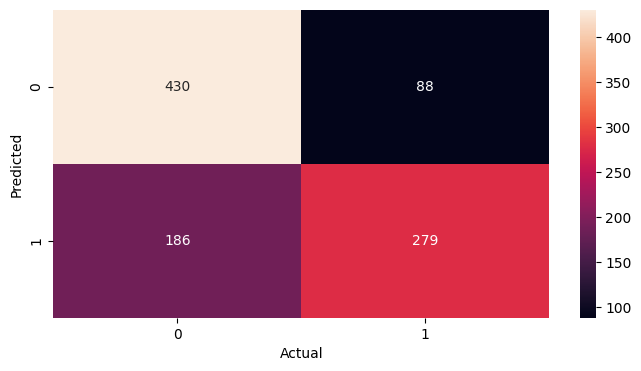

In [42]:
plt.figure(figsize = (8, 4))
sns.heatmap(confusion_matrix(labels_test, classes_test), annot = True, fmt = '.0f')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()